In [4]:
#import
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium import webdriver
import requests
import time, os
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns




# For storing
#pickle.dump(name_of_object, open("name_of_file.pickle", "wb" ))
#pickle.dump(cont_country_df,open("cont_country_dict.pickle", "wb" ))
#pickle.dump(master_df,open("master_df.pickle", "wb" ))
#pickle.dump(dumb_master_df,open("dumb_master_df.pickle", "wb" ))


# For loading
cont_country_dict=pickle.load( open("CONT_COUNTRY_DICT.pickle", "rb"))
player_pot = pickle.load( open("player_pot.pickle", "rb"))
whole_pot = pickle.load( open("whole_pot.pickle", "rb"))
master_df = pickle.load( open("master_df.pickle", "rb"))


In [20]:
#set browser
driver = webdriver.Safari()
#get the data!
driver.get('https://fbref.com/en/comps/9/history/Premier-League-Seasons')
# create action chain object
action = ActionChains(driver)
#driver.quit()


In [21]:
#create soup to page source
soup = bs(driver.page_source)
#create empty list to store links to each season's data
season_links=[]
#fill list above with year and link to that season's data
for season in soup.find_all(scope='row',class_='left'):
    season_links.append((season.find('a').text, season.find('a', href=True)['href']))





In [22]:
season_links

[('2021-2022', '/en/comps/9/Premier-League-Stats'),
 ('2020-2021', '/en/comps/9/10728/2020-2021-Premier-League-Stats'),
 ('2019-2020', '/en/comps/9/3232/2019-2020-Premier-League-Stats'),
 ('2018-2019', '/en/comps/9/1889/2018-2019-Premier-League-Stats'),
 ('2017-2018', '/en/comps/9/1631/2017-2018-Premier-League-Stats'),
 ('2016-2017', '/en/comps/9/1526/2016-2017-Premier-League-Stats'),
 ('2015-2016', '/en/comps/9/1467/2015-2016-Premier-League-Stats'),
 ('2014-2015', '/en/comps/9/733/2014-2015-Premier-League-Stats'),
 ('2013-2014', '/en/comps/9/669/2013-2014-Premier-League-Stats'),
 ('2012-2013', '/en/comps/9/602/2012-2013-Premier-League-Stats'),
 ('2011-2012', '/en/comps/9/534/2011-2012-Premier-League-Stats'),
 ('2010-2011', '/en/comps/9/467/2010-2011-Premier-League-Stats'),
 ('2009-2010', '/en/comps/9/400/2009-2010-Premier-League-Stats'),
 ('2008-2009', '/en/comps/9/338/2008-2009-Premier-League-Stats'),
 ('2007-2008', '/en/comps/9/282/2007-2008-Premier-League-Stats'),
 ('2006-2007', '/

## Going to click on each team of each season and extract data for each player of each team



## OK, grabbed each link for each team. next is grab each player's stats from each table

In [23]:
#save links as a series
links=pd.Series([x[1] for x in season_links])
#and years as a series as well
years=[x[0] for x in season_links]
#base url
stable_link='https://fbref.com'
#merge the base url with the the links from the series above
links=stable_link+links
    
    
#link and the table number that we want
def go_get(link, i, j):
    #input is beginning of the link, second will be the rest of the link to the season data
    #go to season page
    driver.get(link)
    #create a soup (soup-YUM!)
    soup_sample=driver.find_elements_by_tag_name('table')[i].get_attribute('outerHTML')
    #read data in table
    soup_sample=pd.read_html(soup_sample, header = j)
    #save as dataframe
    soup_sample=pd.concat(soup_sample)
    return soup_sample


#creating dictionary that takes the league table data from each season an save as library with the key as the season year
whole_pot=dict(zip(years,(go_get(x, 9, 1) for x in links)))


# Changing project here. Now going to predict goals per 90 mins by scraping past 5 years player data 

## Scrape general player data
### save in dict w/key as year

In [25]:
#split the data into lists to insert '/stats/'
player_stat_links=[]
split_links=[]
split_links=[link.split('/') for link in links]
#re-join the list into string separated by "/" with "stats" inserted. This will bring us to the page where the player data lives
player_stat_links=[("/".join(split_links[i][:-1]))+'/stats/'+("/".join(split_links[i][-1:])) for i in list(range(len(split_links)))]
#the most recent season is an anomoly, so appending the missing text to make link match 
player_stat_links[0]=player_stat_links[0]#+'Premier-League-Stats'
#converting to series to add the beginning of link 
player_stat_links=pd.Series(player_stat_links)
#create dictionary for player data for all years
player_pot=dict(zip(years,(go_get(x, 11, 1) for x in player_stat_links)))



## Scrape player shooting data
### save in dict w/key as year

In [27]:
#https://fbref.com/en/comps/9/shooting/Premier-League-Stats
player_shoot_links=[]
#re-join the list into string separated by "/" with "shooting" inserted. This will bring us to the page where the player data lives
player_shoot_links=[("/".join(split_links[i][:-1]))+'/shooting/'+("/".join(split_links[i][-1:])) for i in list(range(len(split_links)))]
#the most recent season is an anomoly, so appending the missing text to make link match 
player_shoot_links[0]=player_shoot_links[0]+'Premier-League-Stats'
#converting to series to add the beginning of link 
player_shoot_links=pd.Series(player_shoot_links)
#create dictionary for player data for all years
shoot_pot=dict(zip(years,(go_get(x, 11, 1) for x in player_shoot_links)))

## Scrape player goals and shot creation data
### save in dict w/key as year

In [28]:
#https://fbref.com/en/comps/9/gca/Premier-League-Stats
player_gca_links=[]
#re-join the list into string separated by "/" with "gca" inserted. This will bring us to the page where the player data lives
player_gca_links=[("/".join(split_links[i][:-1]))+'/gca/'+("/".join(split_links[i][-1:])) for i in list(range(len(split_links)))]
#the most recent season is an anomoly, so appending the missing text to make link match 
player_gca_links[0]=player_gca_links[0]+'Premier-League-Stats'
#converting to series to add the beginning of link 
player_gca_links=pd.Series(player_gca_links)
#create dictionary for player data for all years
gca_pot=dict(zip(years,(go_get(x, 11, 1) for x in player_gca_links)))


## Scrape player misc data
### save in dict w/key as year

In [54]:
#https://fbref.com/en/comps/9/misc/Premier-League-Stats
player_misc_links=[]
#re-join the list into string separated by "/" with "misc" inserted. This will bring us to the page where the player data lives
player_misc_links=[("/".join(split_links[i][:-1]))+'/misc/'+("/".join(split_links[i][-1:])) for i in list(range(len(split_links)))]
#the most recent season is an anomoly, so appending the missing text to make link match 
player_misc_links[0]=player_misc_links[0]+'Premier-League-Stats'
#converting to series to add the beginning of link 
player_misc_links=pd.Series(player_misc_links)
#create dictionary for player data for all years
misc_pot=dict(zip(years,(go_get(x, 11, 1) for x in player_misc_links)))

## Data from the misc, shooting, and goal/shot creation wasn't uploaded until 2017-2018 :(

In [180]:
from functools import reduce
ten_years=['2020-2021', '2019-2020', '2018-2019', '2017-2018']#, '2016-2017', '2015-2016', '2014-2015', '2013-2014', '2012-2013', '2011-2012', '2010-2011', '2009-2010']
master_df=pd.DataFrame()
for key in ten_years:
    master_df=master_df.append(reduce(lambda x,y: pd.merge(x,y, on=['Player', 'Nation', 'Pos', 'Squad', 'Age'], how='left'),
                                      [player_pot[key],shoot_pot[key], gca_pot[key],misc_pot[key]]))


- Select data from the past 10 years only
- Merge each year data into a single dataframe


In [181]:
master_df

,Rk_x,Player,Nation,Pos,Squad,Age,Born_x,MP,Starts,Min,...,Int,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Matches_y
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,29,1990,22,20,1777,...,34,19,0,0,0,179,10,11,47.6,Matches
1,2,Tammy Abraham,eng ENG,FW,Chelsea,22,1997,22,12,1040,...,2,4,1,0,0,47,39,28,58.2,Matches
2,3,Che Adams,sct SCO,FW,Southampton,24,1996,36,30,2667,...,11,17,0,0,0,119,47,141,25.0,Matches
3,4,Tosin Adarabioyo,eng ENG,DF,Fulham,22,1997,33,33,2953,...,55,26,0,1,1,278,100,39,71.9,Matches
4,5,Adrián,es ESP,GK,Liverpool,33,1987,3,3,270,...,0,0,0,0,0,20,0,0,NaN,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195005,Rk,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,Int,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Matches
195006,526,Davide Zappacosta,it ITA,DF,Chelsea,25,1992,22,12,1098,...,12,13,0,0,0,98,14,6,70.0,Matches
195007,527,Marvin Zeegelaar,nl NED,DF,Watford,26,1990,12,12,994,...,22,19,0,0,0,113,22,11,66.7,Matches
195008,528,Oleksandr Zinchenko,ua UKR,DF,Manchester City,20,1996,8,6,532,...,9,9,0,0,0,59,15,5,75.0,Matches


In [182]:
master_df=master_df[(master_df['Player']!='Player')]
master_df=master_df[['Player', 'Nation', 'Pos', 'Squad', 'Age', 'MP',
       'Starts', 'Min', '90s_x', 'Gls_x', 'Ast', 'G-PK', 'PK_x', 'PKatt_x',
       'CrdY_x', 'CrdR_x', 'Gls.1', 'Ast.1', 'G+A', 'G-PK.1', 'G+A-PK', 'Sh_x',
       'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK','SCA', 'SCA90', 'PassLive', 'PassDead',
       'Drib', 'Sh_y', 'Fld_x', 'Def', 'GCA', 'GCA90', 'PassLive.1',
       'PassDead.1', 'Drib.1', 'Sh.1', 'Fld.1', 'Def.1','2CrdY', 'Fls', 'Fld_y', 'Off',
       'Crs', 'Int', 'TklW', 'PKwon', 'PKcon', 'OG', 'Recov', 'Won', 'Lost',
       'Won%']]

In [183]:
master_df.rename(columns={'MP': 'matches_played','90s_x':'mins_played_div_90','Ast':'assists', 'Gls_x': 'goals_scored','G-PK':'non_penalty_goals','G-PK.1':'non_penalty_goals_per_90',
                          'PK_x':'penalties_scored','PKatt_x':'pks_attempted',
                       'CrdY_x':'yellow_cards:','CrdR_x':'red_cards','Gls.1':'goals_per_90','Ast.1':'assists_per_90','G+A':'goals_and_assists_per_90',
                       'G+A-PK':'non_penalty_goals_and_assists','Sh_x':'shots','SoT':'shots_on_target','SoT%':'shots_on_target_percentage',
                          'Sh/90':'shots_per_90','SoT/90':'shots_on_target_per_90',
                       'G/Sh':'goals_per_shot','G/SoT':'goals_per_shot_on_target','Dist':'average_distance_shots_taken','FK':'shots_from_free_kicks',
                       'SCA':'shot_creating_action','SCA90':'shot_creating_action_per_90','PassLive':'live_passes_led_to_shot','PassDead':'dead_passes_led_to_shot',
                       'Drib':'dribbles_led_to_shot','GCA':'goal_creating_action','GCA90':'goal_creating_action_per_90','PassLive.1':'live_passes_led_to_goal',
                        'PassDead.1':'dead_passes_led_to_goal','Drib.1':'dribbles_led_to_goal','Sh_y':'shot_led_to_shot_attempt', 'Fld_x':'foul_draw_led_to_shot', 
                        'Def':'defensive_action_led_to_shot','Sh.1':'shot_led_to_shot_goal', 'Fld.1':'foul_draw_led_to_goal', 
                        'Def.1':'defensive_action_led_to_goal','2CrdY':'second_yellow_card','Fls':'fouls_committed', 'Fld_y':'fouls_drawn', 'Off':'offsides',
                        'Crs':'crosses', 'Int':'interceptions', 'TklW':'tackles_won', 'PKwon':'pks_won', 'PKcon':'pk_conceded', 'OG':'own_goals', 'Recov':'loose_balls_recovered',
                        'Won':'aerials_won', 'Lost':'aerials_lost','Won%':'percent_aerials_won'}, inplace=True)

master_df=master_df.loc[:,~master_df.columns.duplicated()]

- Convert specified column datatypes to numeric from 'object'

In [412]:
num_cols=list(master_df.columns[4:])
master_df[num_cols]=master_df[num_cols].apply(pd.to_numeric)
master_df.dtypes

Index(['Player', 'Code', 'Pos', 'Squad', 'Age', 'matches_played', 'Starts',
       'Min', 'mins_played_div_90', 'goals_scored', 'assists',
       'non_penalty_goals', 'penalties_scored', 'pks_attempted',
       'yellow_cards:', 'red_cards', 'goals_per_90', 'assists_per_90',
       'goals_and_assists_per_90', 'non_penalty_goals_per_90',
       'non_penalty_goals_and_assists', 'shots', 'shots_on_target',
       'shots_on_target_percentage', 'shots_per_90', 'shots_on_target_per_90',
       'goals_per_shot', 'goals_per_shot_on_target',
       'average_distance_shots_taken', 'shots_from_free_kicks',
       'shot_creating_action', 'shot_creating_action_per_90',
       'live_passes_led_to_shot', 'dead_passes_led_to_shot',
       'dribbles_led_to_shot', 'shot_led_to_shot_attempt',
       'foul_draw_led_to_shot', 'defensive_action_led_to_shot',
       'goal_creating_action', 'goal_creating_action_per_90',
       'live_passes_led_to_goal', 'dead_passes_led_to_goal',
       'dribbles_led_to_goal'

- isolate the three code country value and save as nation

In [185]:
master_df[['Nation', 'Pos', 'Squad']].nunique()

master_df['Nation']=master_df['Nation'].astype(str).str.split().str[1]


- modify existing go_get fxn to grab only the three letter country code 

In [186]:
def get_cont(link, i, j):
    #input is beginning of the link, second will be the rest of the link to the season data
    #go to season page
    driver.get(link)
    #create a soup (soup-YUM!)
    soup_sample=driver.find_elements_by_tag_name('table')[i].get_attribute('outerHTML')
    #read data in table
    soup_sample=pd.read_html(soup_sample, header = j)
    #save as dataframe
    soup_sample=pd.concat(soup_sample)
    return soup_sample['3-Letter']

- grab country codes from website that have matches to continent. Found out they don't all match. hence, the manual checks below. sigh. 

In [187]:
continent_link ='https://abbreviations.yourdictionary.com/articles/country-abbreviations.html'

cont=soup.find_all('h3')
cont=[c.text for c in cont]
cont = ['Africa','Antarctica','Oceania','Asia','Europe','North America','South America']

cont_dict=dict(zip(cont,(get_cont(continent_link, x, 0) for x in list(range(len(cont))))))

def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = key 
    return inverse

cont_dict=invert_dict(cont_dict)
cont_dict.update({
    'NED':'Europe',
    'ENG':'Europe',
    'SCO':'Europe',
    'PAR':'South America',
    'WAL':'Europe',
    'DEN':'Europe',
    'ALG':'Africa',
    'SUI':'Europe',
    'POR':'Europe',
    'URU':'South America',
    'NIR':'Europe',
    'GER':'Europe',
    'MTN':'Africa',
    'GUI':'Africa',
    'CRO':'Europe',
    'RSA':'Africa',
    'ZIM':'Africa',
    'SKN':'North America',
    'GRE':'Europe',
    'CHI':'South America', 
    'TAN':'Africa', 
    'TOG':'Africa', 
    'PHI':'Asia',
    'KVX':'Europe',
    'EQG':'Africa',
    'BER':'North America',
    'GAM':'Africa',
    'CRC':'South America', 
    'HON':'South America',
    'ZAM':'Africa',
    'BUL':'Europe',
    'CGO':'Africa', 
    'TRI':'South America', 
    'BRB':'North America',
    'OMA':'Asia',
    'ATG':'North America',
    'GRN':'North America',
    'ENG':'Europe', 
    'SCO':'Europe',
    'NGA':'Africa',
    'MKD':'Europe',
    'WAL':'Europe',
    'CIV':'Africa',
    'CZE':'Europe',
    'NIR':'Europe', 
    'SVK':'Europe',
    'KOR':'Asia',
    'IRN':'Asia',
    'COD':'Africa',
    'USA':'North America',
    'BFA':'Africa',
    'CUW':'South America',
    'SVN':'Europe',
    'KVX':'Europe',
    'EQG':'Africa',
    'BER':'North America'})




- check the every player has a continent matched with it

,2-Letter,3-Letter,Country Name,Continent
0,DZ,DZA,Algeria,Africa
1,AO,AGO,Angola,Africa
2,BJ,BEN,Benin,Africa
3,BW,BWA,Botswana,Africa
4,BF,BFA,Burkina Faso,Africa
...,...,...,...,...
9,PY,PRY,Paraguay,South America
10,PE,PER,Peru,South America
11,SR,SUR,Suriname,South America
12,UY,URY,Uruguay,South America


In [196]:
cont_country_df

,2-Letter,3-Letter,Country Name,Continent
0,DZ,DZA,Algeria,Africa
1,AO,AGO,Angola,Africa
2,BJ,BEN,Benin,Africa
3,BW,BWA,Botswana,Africa
4,BF,BFA,Burkina Faso,Africa
...,...,...,...,...
9,PY,PRY,Paraguay,South America
10,PE,PER,Peru,South America
11,SR,SUR,Suriname,South America
12,UY,URY,Uruguay,South America


In [188]:
driver.get('https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)')
gdp=driver.find_elements_by_tag_name('table')[2].get_attribute('outerHTML')
#read data in table
gdp=pd.read_html(gdp, header = 1)
#save as dataframe
gdp=pd.concat(gdp)




In [195]:
# This works but throws an error...

cont_country_df=cont_country_dict.copy()
#for key in cont_country_dict:
#    try:
#        new_df=pd.DataFrame.from_dict(cont_country_dict[key])
#        new_df['Continent']=str(key)
#        cont_country_df=cont_country_df.append(new_df)
#    except ValueError:
#        pass

In [207]:
driver.get('https://en.wikipedia.org/wiki/List_of_IOC_country_codes')
ico=driver.find_elements_by_tag_name('table')[0].get_attribute('outerHTML')
ico=pd.read_html(ico, header = 0)
ico_df=pd.concat(ico)

ico_df.loc[ico_df['National Olympic Committee'] =='Afghanistan', 'Code'] = "AFG"
ico_df.rename(columns={'National Olympic Committee':'country'}, inplace=True)

In [2]:
#cont_country_df #good
#gdp_ico #good 
#merged_df['Code'] #good 
#master_df #good ALB
#test #good
master_df

,Player,Code,Pos,Squad,Age,matches_played,Starts,Min,mins_played_div_90,goals_scored,...,Continent,Other codes used,Link,Region,Estimate,Year,Estimate.1,Year.1,Estimate.2,Year.2
0,Patrick van Aanholt,NED,DEF,Not,29,22,20,1777,19.7,0,...,Europe,OLA (1956 W) from Italian OlandaNET (1960 W)PB...,[138],Europe,1012598.0,2021,907050.0,2020,912242.0,2020
1,Tammy Abraham,ENG,ATT,Top,22,22,12,1040,11.6,6,...,Europe,NaN,NaN,NaN,NaN,NaN,2826441.0,NaN,NaN,NaN
2,Che Adams,SCO,ATT,Not,24,36,30,2667,29.6,9,...,Europe,NaN,NaN,NaN,NaN,NaN,2826441.0,NaN,NaN,NaN
3,Tosin Adarabioyo,ENG,DEF,Not,22,33,33,2953,32.8,0,...,Europe,NaN,NaN,NaN,NaN,NaN,2826441.0,NaN,NaN,NaN
4,Adrián,ESP,GKO,Top,33,3,3,270,3.0,0,...,Europe,SPA (1956–19641968 W)current code taken from F...,[62],Europe,1461552.0,2021,1393490.0,2020,1281199.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,Wilfried Zaha,CIV,ATT,Not,24,29,28,2549,28.3,9,...,Africa,IVC (1964)CML (1968) from Spanish Costa de Mar...,[42],Africa,70991.0,2021,58539.0,2020,61349.0,2020
2087,Davide Zappacosta,ITA,DEF,Top,25,22,12,1098,12.2,1,...,Europe,NaN,[95],Europe,2106287.0,2021,2003576.0,2020,1886445.0,2020
2088,Marvin Zeegelaar,NED,DEF,Not,26,12,12,994,11.0,0,...,Europe,OLA (1956 W) from Italian OlandaNET (1960 W)PB...,[138],Europe,1012598.0,2021,907050.0,2020,912242.0,2020
2089,Oleksandr Zinchenko,UKR,DEF,Top,20,8,6,532,5.9,0,...,Europe,NaN,[198],Europe,164593.0,[n 6]2021,153781.0,[n 6]2020,155582.0,2020


In [200]:
#convert datatypes to string
gdp['Country or territory']=[x[:-6] for x in gdp['Country or territory']]

cont_country_df['Country Name']=cont_country_df['Country Name'].apply(str.strip)
gdp['Country or territory']=gdp['Country or territory'].apply(str.strip)

cont_country_df['Country Name'].isin(gdp['Country or territory'])

#rename columns to match and merge
gdp.rename(columns={'Country or territory': 'country'}, inplace=True)
cont_country_df.rename(columns={'Country Name':'country'}, inplace=True)
master_df.rename(columns={'Nation':'Code'}, inplace= True)


In [173]:
(gdp['country']=='United States').sum()
(ico_df['country']=='United States').sum()
(cont_country_df['country']=='United States').sum()

0

-since ico and gdp have same name for US, we'll merge those two first...

In [211]:
gdp_ico= ico_df.merge(gdp, how = 'outer', on = 'country')

In [229]:
merged_df = cont_country_df.merge(gdp_ico, how = 'outer', on = 'country')

master_df=master_df.merge(merged_df,how='left', on='Code')


In [230]:
master_df.loc[master_df['Code'] =='BFA', 'Estimate.1'] = 15990
master_df.loc[master_df['Code'] =='COD', 'Estimate.1'] = 47319
master_df.loc[master_df['Code'] =='CUW', 'Estimate.1'] = 3101
master_df.loc[master_df['Code'] =='ENG', 'Estimate.1'] = 2826441
master_df.loc[master_df['Code'] =='EQG', 'Estimate.1'] = 11024
master_df.loc[master_df['Code'] =='IRN', 'Estimate.1'] = 603779
master_df.loc[master_df['Code'] =='KVX', 'Estimate.1'] = 7952
master_df.loc[master_df['Code'] =='NGA', 'Estimate.1'] = 474516	
master_df.loc[master_df['Code'] =='NIR', 'Estimate.1'] = 2826441
master_df.loc[master_df['Code'] =='SCO', 'Estimate.1'] = 2826441
master_df.loc[master_df['Code'] =='SVN', 'Estimate.1'] = 54174
master_df.loc[master_df['Code'] =='WAL', 'Estimate.1'] = 2826441


In [232]:
top_six = ['Arsenal','Chelsea','Liverpool','Manchester City','Manchester Utd','Tottenham']

master_df.loc[master_df['Squad'].isin(top_six), 'Squad'] = 'Top'

master_df.loc[master_df['Squad']!='Top', 'Squad'] = 'Not'

attack=['MF','FW','FW,MF','MF,FW']
defense=['DF','DF,MF','MF,DF']
GK_other=['GK', 'DF,FW', 'FW,DF', 'GK,MF']

master_df.loc[master_df['Pos'].isin(attack), 'Pos'] = 'ATT'
master_df.loc[master_df['Pos'].isin(defense), 'Pos'] = 'DEF'
master_df.loc[master_df['Pos'].isin(GK_other), 'Pos'] = 'GKO'


In [668]:
master_df['Continent']=master_df['Code'].map(cont_dict)



# Start from here once master_df is unpickled

In [5]:
dumb_master_df=master_df.copy()

dumb_master_df.loc[master_df['Continent'] =='Asia', 'Continent'] = 'other'
dumb_master_df.loc[master_df['Continent'] =='North America', 'Continent'] = 'other'
dumb_master_df.loc[master_df['Continent'] =='Oceania', 'Continent'] = 'other'

In [6]:
dumb_master_df = pd.get_dummies(dumb_master_df, columns=['Pos','Squad','Continent'],
                            drop_first=True)

In [7]:
dumb_master_df['gpdXeurope']=dumb_master_df['Estimate.1']*dumb_master_df['Continent_Europe']
dumb_master_df['gpdXSA']=dumb_master_df['Estimate.1']*dumb_master_df['Continent_South America']
dumb_master_df['gpdXo']=dumb_master_df['Estimate.1']*dumb_master_df['Continent_other']
dumb_master_df['DefXshots']=dumb_master_df['shots']*dumb_master_df['Pos_DEF']
dumb_master_df['GKOXshots']=dumb_master_df['shots']*dumb_master_df['Pos_GKO']





In [408]:
dumb_master_df.describe()

,Age,matches_played,Starts,Min,mins_played_div_90,goals_scored,assists,non_penalty_goals,penalties_scored,pks_attempted,...,Pos_GKO,Squad_Top,Continent_Europe,Continent_South America,Continent_other,gpdXeurope,gpdXSA,gpdXo,DefXshots,GKOXshots
count,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.00000,2091.000000,2091.000000,2091.000000,...,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2.091000e+03,2.091000e+03,2.091000e+03,2090.000000,2090.000000
mean,25.708752,20.054519,15.992348,1436.829747,15.964562,1.920134,1.36681,1.769967,0.150167,0.191296,...,0.088474,0.303682,0.775227,0.083214,0.047824,1.593663e+06,8.392223e+04,2.245280e+05,3.640191,0.162679
std,4.249944,11.823013,11.942203,1041.697039,11.575205,3.521748,2.18188,3.186271,0.714460,0.849284,...,0.284052,0.459957,0.417532,0.276271,0.213445,1.302951e+06,3.538712e+05,1.960364e+06,7.494099,2.305392
min,15.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,23.000000,10.000000,5.000000,467.000000,5.200000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.050790e+05,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,26.000000,21.000000,15.000000,1348.000000,15.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.393490e+06,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,29.000000,30.000000,26.000000,2297.000000,25.500000,2.000000,2.00000,2.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,2.826441e+06,0.000000e+00,0.000000e+00,4.000000,0.000000
max,39.000000,38.000000,38.000000,3420.000000,38.000000,32.000000,20.00000,31.000000,10.000000,11.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,3.861123e+06,1.847795e+06,2.143323e+07,65.000000,61.000000


## Can remove boxcox :(

In [195]:
#numeric_cols = [col for col in X if X[col].dtype.kind != 'O']
#numeric_cols
#X[numeric_cols] += 1
X['shots'] += 1
#X['average_distance_shots_taken'] += 1
#X['tackles_won']+=1
#X['DefXshots']+=1
X.head()
test_bc=pd.DataFrame()

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 

#Box-Cox Transform
column_trans = ColumnTransformer(
    [('shots_bc', PowerTransformer(method='box-cox', standardize=True), ['shots'])])#,
     #('average_distance_shots_taken_bc', PowerTransformer(method='box-cox', standardize=True), ['average_distance_shots_taken']),
    # ('tackles_won_bc', PowerTransformer(method='box-cox', standardize=True), ['tackles_won']),#])#,
     #('Pos_DEF_bc', PowerTransformer(method='box-cox', standardize=True), ['Pos_DEF']),  
     #('Pos_GKO_bc', PowerTransformer(method='box-cox', standardize=True), ['Pos_GKO']),  
     #('Squad_Top_bc', PowerTransformer(method='box-cox', standardize=True), ['Squad_Top']),  
     #('Continent_Europe_bc', PowerTransformer(method='box-cox', standardize=True), ['Continent_Europe']),  
     #('Continent_South America_bc', PowerTransformer(method='box-cox', standardize=True), ['Continent_South America']),     
    #('Continent_other_bc', PowerTransformer(method='box-cox', standardize=True), ['Continent_other']),
    #('DefXshots_bc', PowerTransformer(method='box-cox', standardize=True), ['DefXshots'])])
    #('GKOXshots_bc', PowerTransformer(method='box-cox', standardize=True), ['GKOXshots'])])




transformed_boxcox = column_trans.fit_transform(X)
test_bc = pd.DataFrame(transformed_boxcox)
pd.concat([test_bc], axis = 1)
test_bc.max()

#sns.histplot(data=X, x ='')

0    2.522251
dtype: float64

In [196]:
test_bc=test_bc.set_index(X.index)
X['shots']=test_bc[0]
#X['average_distance_shots_taken']=test_bc[1]
#X['tackles_won']=test_bc[1]
#X['DefXshots']=test_bc[2]


In [197]:
y=y+1

y=pd.DataFrame(y)

#Box-Cox Transform
y_trans = ColumnTransformer(
    [('non_penalty_goals_bc', PowerTransformer(method='box-cox', standardize=True), ['non_penalty_goals'])])



y_boxcox = y_trans.fit_transform(y)
y_bc = pd.DataFrame(y_boxcox)
pd.concat([y_bc], axis = 1)
y_bc.max()
y=y_bc

<AxesSubplot:ylabel='Count'>

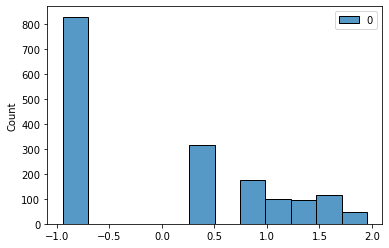

In [198]:
sns.histplot(y)

In [405]:
## exp test
X['shots']=X['shots']**(1/2) 
#X['average_distance_shots_taken']=test_bc[1]
X['tackles_won']=X['tackles_won']**(1/2)
#X['DefXshots']=X['DefXshots']**(1/2)



## LEFT OFF HERE 

- dataframe contains NAs. After peeking with code below, these should be set to zero. eg. someone who doesn't have playing time will have 0 shot on goal... 

# Yikes! BoxCox made decreased r^2. 

<AxesSubplot:xlabel='non_penalty_goals', ylabel='Count'>

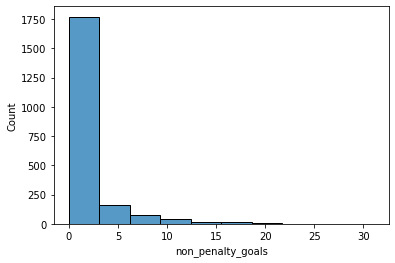

In [18]:
sns.histplot(data=dumb_master_df, x = 'non_penalty_goals', bins=10)


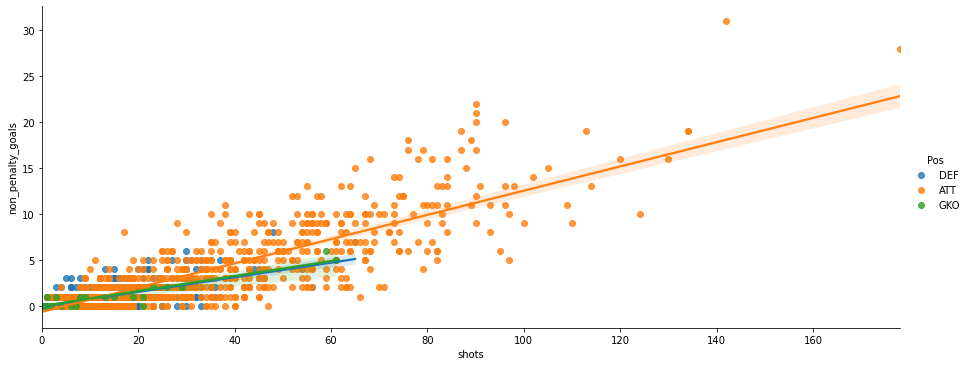

In [268]:
sns.lmplot(x = 'shots',
           y = 'non_penalty_goals',
           hue = 'Pos',
           data = master_df,
           height=5, 
           aspect=2.5)

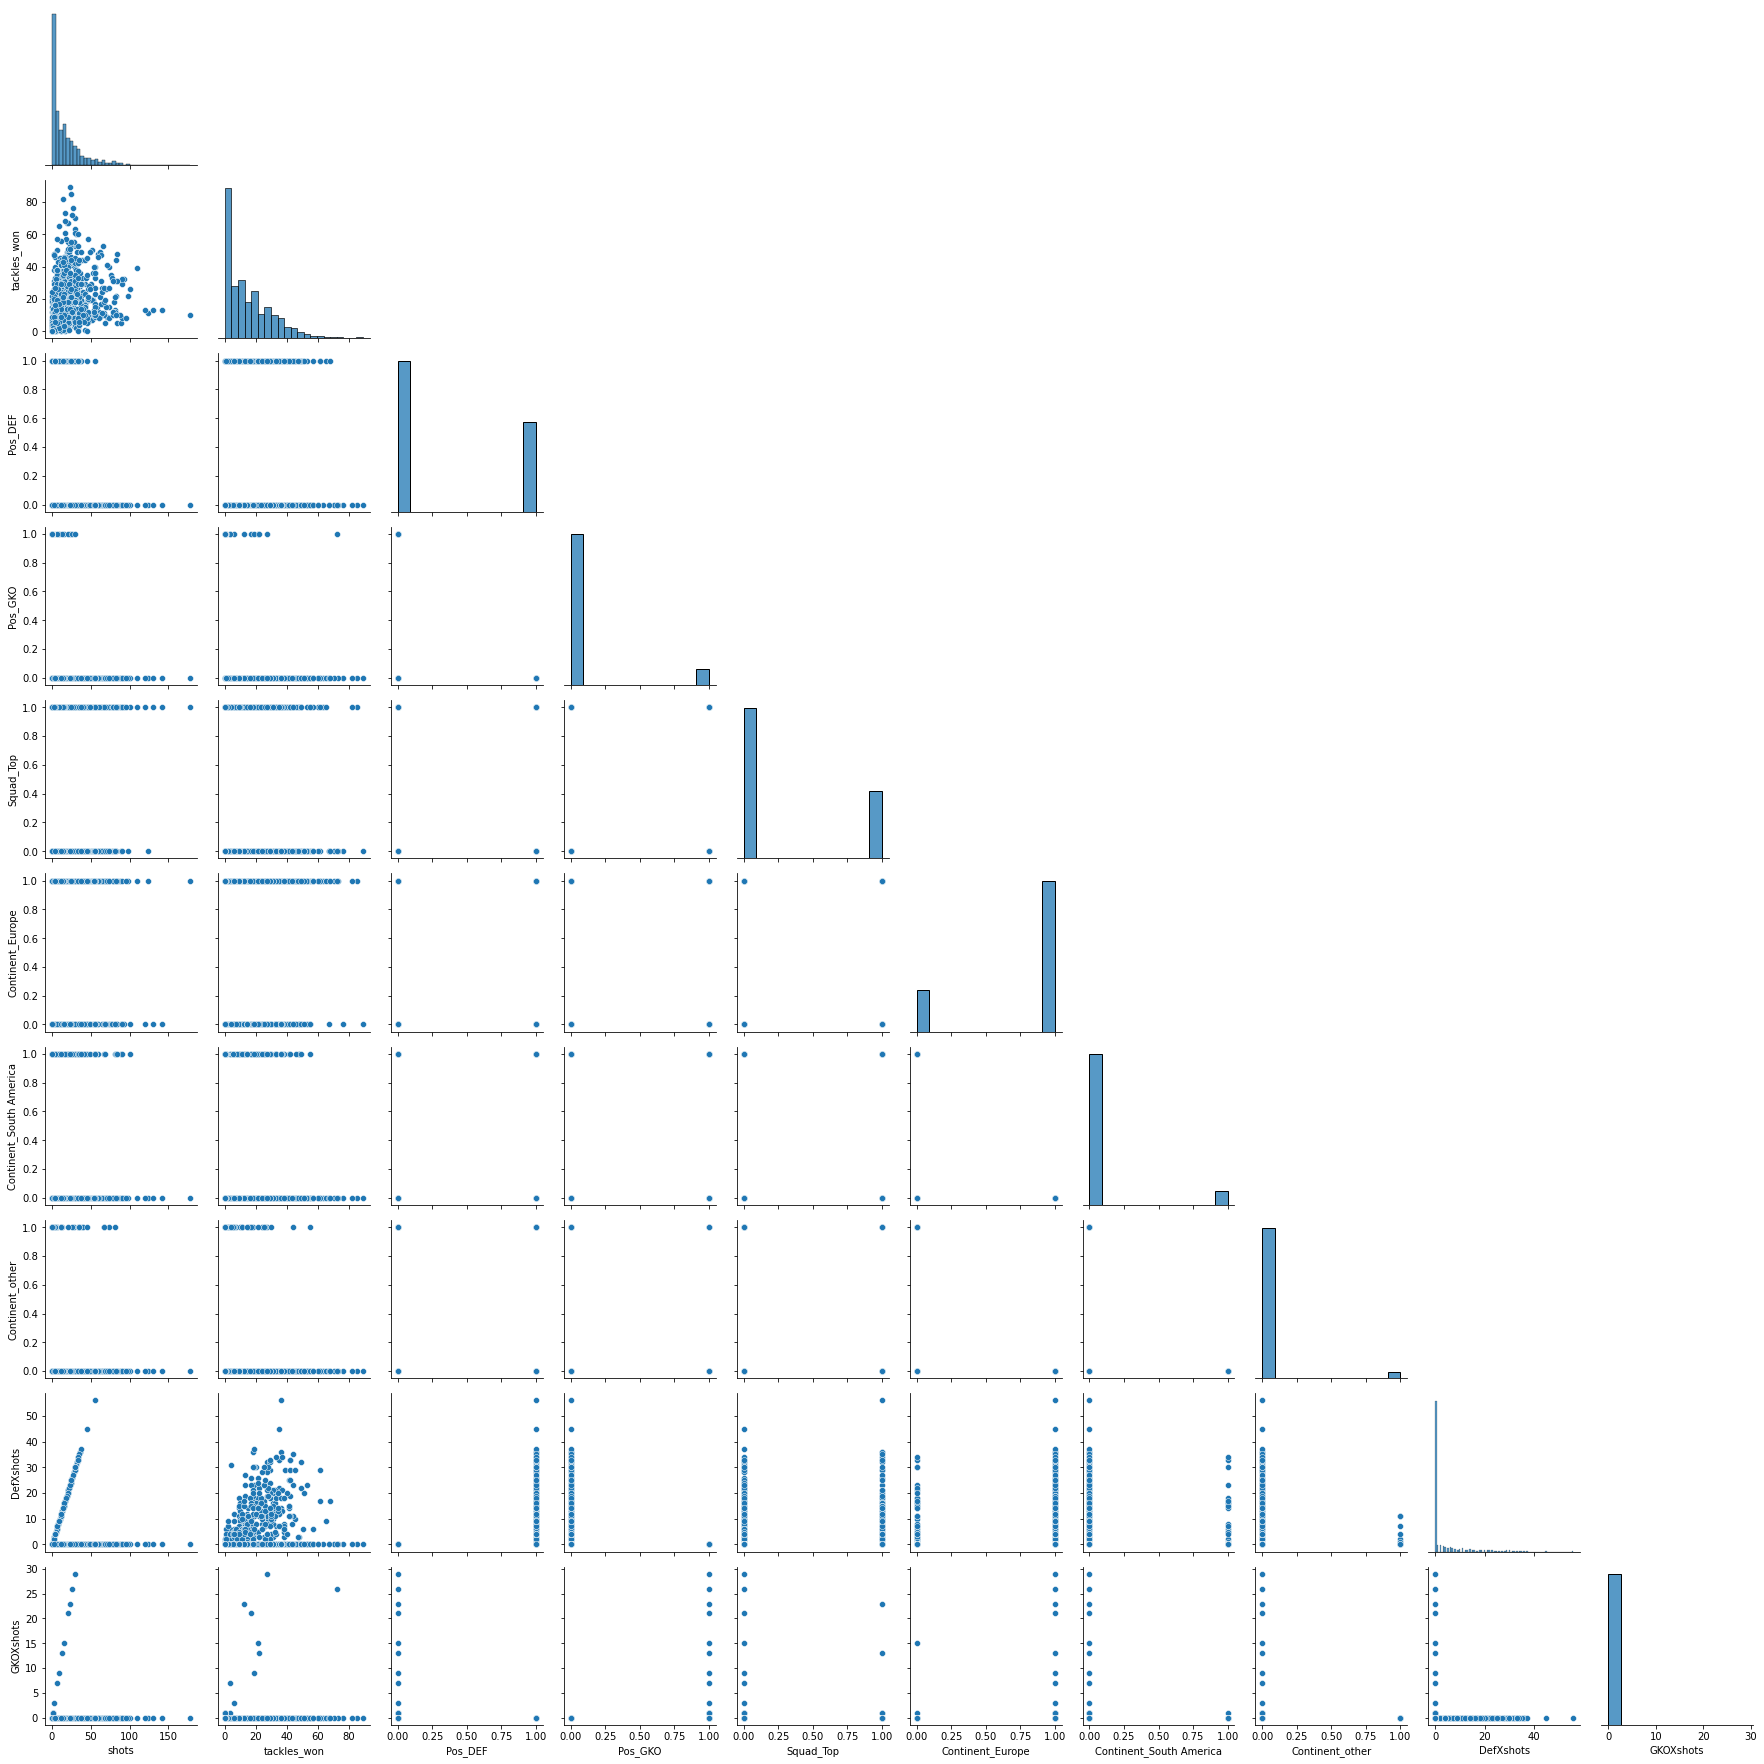

In [47]:



g = sns.PairGrid(X.sample(frac=0.6), diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, kde=False)

In [124]:
#dumb_master_df.iloc[(dumb_master_df['Estimate.1'].idxmax())]
#master_df[(master_df['Code']=='USA')]
#X['average_distance_shots_taken'].hist(bins=100)

import statsmodels.api as sm
import statsmodels.formula.api as smf 

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

results.summary()


influence = results.get_influence()
influence_frame=influence.summary_frame()

influence_frame['cooks_d'].max()#sort_values(axis=1, ascending=False)
#import matplotlib.pyplot as plt
#fig,ax=plt.subplots()
#fig=sm.graphics.plot_fit(results,3,ax=ax)

#sns.barplot(y='cooks_d',
#           x=influence_frame.index,
#           data=influence_frame)




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      non_penalty_goals   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     837.2
Date:                Tue, 14 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:13:58   Log-Likelihood:                -3160.0
No. Observations:                1672   AIC:                             6334.
Df Residuals:                    1665   BIC:                             6372.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7445      0.078     -9.511      0.000      -0.898      -0.591
shots          0.1310      0.002     62.811      0.000       0.127       0.135
Pos_DEF        0.5675      0.119      4.781      0.000       0.335       0.800
Pos_GKO        0.6155      0.154      4.002      0.000       0.314       0.917
Squad_Top      0.4157      0.086      4.842      0.000       0.247       0.584
DefXshots     -0.0513      0.007     -7.352      0.000      -0.065      -0.038
GKOXshots     -0.0487      0.016     -3.016      0.003      -0.080      -0.017
==============================================================================
Omnibus:                      481.879   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5723.576
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                      11.841   Cond. No.                         123.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [409]:
import seaborn as sns
#sns.lmplot(x = 'shots',
#           y = 'non_penalty_goals',
#           hue = 'Pos',
#           data = master_df,
#           height=5, 
#           aspect=2.5)



from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.head(50)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [410]:
##actual model 

X=dumb_master_df[['shots',
                  'Pos_DEF',
                  'Pos_GKO', 'Squad_Top',
                  'DefXshots','GKOXshots']]
            
y=dumb_master_df['non_penalty_goals']




col_names=X.columns




In [343]:
#train test split
X, X_test, y, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=10)



In [344]:
X.isna().sum()
#X[(X['average_distance_shots_taken'].isna())]=X[(X['average_distance_shots_taken'].isna())].fillna(0)
#X[(X['DefXshots'].isna())]=X[(X['DefXshots'].isna())].fillna(0)
X[(X['shots'].isna())]=X[(X['shots'].isna())].fillna(0)




#X, X_test, y, y_test = np.array(X), np.array(X_test), np.array(y), np.array(y_test)
#X.max()


In [345]:
#run only if using the modeling below. Else, run statsmodel models
X, X_test, y, y_test = np.array(X), np.array(X_test), np.array(y), np.array(y_test)
#interaction-look at p valeus, keep all if one sig 
#or crossflow 
#shots vs pos
#gdp vs cont




## All x scaled

In [323]:
kf = KFold(n_splits=5, shuffle=True, random_state = 0)
cv_lm_r2s, cv_poly_r2s, cv_lm_reg_r2s, cv_lm_lass_r2s, cv_lm_e_r2s = [], [], [], [], [] #collect the validation results for both models
alphas = 10 ** np.linspace(-2, 2, 200)
alphalist = [.0001, .01,.1,.3,.5,.7,1]
l1_rats = [.1,.5,.7,.9,.95,.99,1]

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    ## SCALE OTHEr REG MODELS
    ## Scale the variables
    std = StandardScaler()
    ## .fit finds the mean and standard deviation of each variable in the training set
    std.fit(X_train)
    X_tr = std.transform(X_train)
    std.fit(X_val)
    X_va = std.transform(X_val)
    
    
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)

    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    cv_poly_r2s.append(lm_poly.score(X_val_poly, y_val).round(3))

    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #lasso
    lasso = LassoCV(alphas = alphas, cv = 5)
    lasso.fit(X_tr, y_train)
    cv_lm_lass_r2s.append(lasso.score(X_va,y_val).round(3))
    
    #ridge 
    ridge_model=RidgeCV(alphas = alphas, cv=5)
    ridge_model.fit(X_tr,y_train)

    cv_lm_reg_r2s.append(ridge_model.score(X_va, y_val).round(3))
    
    #Enet
    enet_model=ElasticNetCV(alphas=alphalist,
            l1_ratio = l1_rats,
            cv =5, max_iter = 50000)
    enet_model.fit(X_tr,y_train)
    cv_lm_e_r2s.append(enet_model.score(X_va, y_val).round(3))
    
    
    
    


print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Lasso scores: \t{cv_lm_lass_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s}')
print(f'eNet scores: \t{cv_lm_e_r2s}')
print(f'poly scores: \t{cv_poly_r2s}')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lass_r2s):.3f} +- {np.std(cv_lm_lass_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'eNet mean cv r^2: {np.mean(cv_lm_e_r2s):.3f} +- {np.std(cv_lm_e_r2s):.3f}')
print(f'poly mean cv r^2: {np.mean(cv_poly_r2s):.3f} +- {np.std(cv_poly_r2s):.3f}')

print(f'Lasso best lambda: {lasso.alpha_}')
print(f'Ridge best lambda: {ridge_model.alpha_}')
print(f'eNet best lambda: {enet_model.alpha_}')
print(f'eNet best l1 ratio: {enet_model.l1_ratio_}')


Simple scores: 	[0.814, 0.676, 0.743, 0.697, 0.739]
Lasso scores: 	[0.782, 0.676, 0.709, 0.666, 0.708]
Ridge scores: 	[0.78, 0.678, 0.708, 0.668, 0.708]
eNet scores: 	[0.783, 0.673, 0.709, 0.665, 0.707]
poly scores: 	[0.828, 0.697, 0.765, 0.72, 0.759]
Simple mean cv r^2: 0.734 +- 0.047
Lasso mean cv r^2: 0.708 +- 0.041
Ridge mean cv r^2: 0.708 +- 0.039
eNet mean cv r^2: 0.707 +- 0.042
poly mean cv r^2: 0.754 +- 0.045
Lasso best lambda: 0.01
Ridge best lambda: 7.842822061337682
eNet best lambda: 0.0001
eNet best l1 ratio: 1.0


In [346]:
poly = PolynomialFeatures(degree=2) 
X_poly = poly.fit_transform(X)

lm_poly = LinearRegression()
lm_poly.fit(X_poly, y)
lm_poly.score(X_poly, y).round(3)


poly_coef=pd.DataFrame(list(zip(col_names, lm_poly.coef_)))



,0,1
0,shots,-2.859106e-16
1,Pos_DEF,8.886581e-02
2,Pos_GKO,9.922211e-02
3,Squad_Top,1.007027e-01
4,DefXshots,-2.080287e-02
5,GKOXshots,-7.681669e-03


In [352]:
std = StandardScaler()
lm = LinearRegression()

#standard model 
lm.fit(X, y)
basic_pred = lm.predict(X_test)

#ridge model 
ridge_model=Ridge(alpha =6.826071834272386)
ridge_model.fit(X,y)
ridge_pred = ridge_model.predict(X_test)

#lasso
lasso = Lasso(alpha = 0.01)
lasso.fit(X, y)
## Apply the scaler to the test set

lasso_pred=lasso.predict(X_test)

#Enet
enet_model=ElasticNet(alpha=0.0001,l1_ratio = 1)
enet_model.fit(X,y)
enet_pred=enet_model.predict(X_test)



poly = PolynomialFeatures(degree=2) 
X_poly = poly.fit_transform(X)
X_poly_test = poly.fit_transform(X_test)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y)
lm_poly_pred=lm_poly.predict(X_poly_test)









#enet_pred = enet_model.predict(X_test)
print(f'basic r^2: {r2_score(y_test, basic_pred)}')
print(f'ridge r^2: {r2_score(y_test, ridge_pred)}')
print(f'lasso r^2: {r2_score(y_test, lasso_pred)}')
print(f'eNet r^2: {r2_score(y_test, enet_pred)}')
print(f'poly r^2: {r2_score(y_test, lm_poly_pred)}')





print(f'basic mse: {mean_squared_error(y_test, basic_pred)}')
print(f'ridge mse: {mean_squared_error(y_test, ridge_pred)}')
print(f'lasso mse: {mean_squared_error(y_test, lasso_pred)}')
print(f'eNet mse: {mean_squared_error(y_test, enet_pred)}')
print(f'poly mse: {mean_squared_error(y_test, lm_poly_pred)}')





print(f'basic mae: {mean_absolute_error(y_test, basic_pred)}')
print(f'ridge mae: {mean_absolute_error(y_test, ridge_pred)}')
print(f'lasso mae: {mean_absolute_error(y_test, lasso_pred)}')
print(f'eNet mae: {mean_absolute_error(y_test, enet_pred)}')
print(f'poly mae: {mean_absolute_error(y_test, lm_poly_pred)}')







basic r^2: 0.779664250433815
ridge r^2: 0.7797012359246395
lasso r^2: 0.7794513651205858
eNet r^2: 0.7796659550074093
poly r^2: 0.7876912102615103
basic mse: 2.0967671070752263
ridge mse: 2.0964151443966674
lasso mse: 2.0987929740679294
eNet mse: 2.096750885949735
poly mse: 2.0203806588040614
basic mae: 0.9451660646222702
ridge mae: 0.9436474895560968
lasso mae: 0.9384783415463178
eNet mae: 0.9450944341392506
poly mae: 0.8707583246253796


In [406]:
import random
random.randint(0, 20)
np.round(lm_poly.predict(X_poly_test[[8]]),1)
y_test[[8]]

array([1])

In [312]:
#get moedl parameters
poly = PolynomialFeatures(degree=2) 
X_poly = poly.fit_transform(X)
X_poly_test = poly.fit_transform(X_test)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y)
lm_poly_pred=lm_poly.predict(X_poly_test)

from sklearn.preprocessing import PolynomialFeatures
import numpy as np


lm_poly.intercept_





-0.20538443889363744

In [ ]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
    


In [55]:
len(X)

1672

<AxesSubplot:xlabel='residuals', ylabel='Count'>

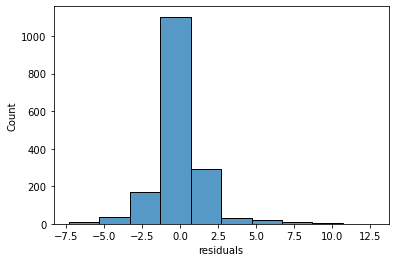

In [341]:
#lasso = Lasso(alpha = 0.01)
lm_poly.fit(X, y)
pred = lm_poly.predict(X)
#pred = clf.predict(X)




#plt.subplot(1, 3, 1)
#plt.scatter(X,y)
#plt.plot(X, pred, color='blue',linewidth=1)



res = y - pred
#plt.scatter(pred, res)
#plt.title("Residual plot")
plt.xlabel("residuals")
#plt.ylabel("residuals")



sns.histplot(res, bins = 10)

### limited by the number of shots (eg more shots more goals)

Text(0.5, 1.0, 'Normal Q-Q plot')

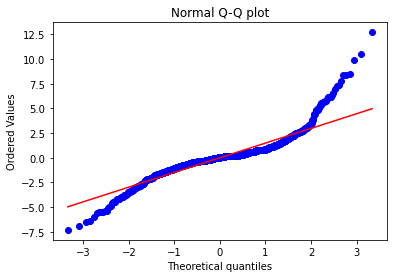

In [253]:
#Generates a probability plot of sample data against the quantiles of a 
# specified theoretical distribution 
stats.probplot(res,plot=plt)
plt.title("Normal Q-Q plot")

#fat tailed 
#non linear (quad) term 

In [66]:
pd.DataFrame(y).value_counts()
pred

array([[-0.83590443],
       [ 0.74417529],
       [ 1.07884783],
       ...,
       [-0.59616011],
       [-0.94589665],
       [ 0.61960845]])

In [2057]:
## next steps
# drop dead date
#tired of coding-build storyboard
#wrap any final modeling by monday
#slides on tues by latest
#standardize other models

In [273]:

poly = PolynomialFeatures(degree=2) 

X = poly.fit_transform(X)


lm_poly = LinearRegression()
lm_poly.fit(X, y)


LinearRegression()

In [274]:
lm_poly.score(X,y)

0.7951628260197184

<Figure size 432x288 with 0 Axes>

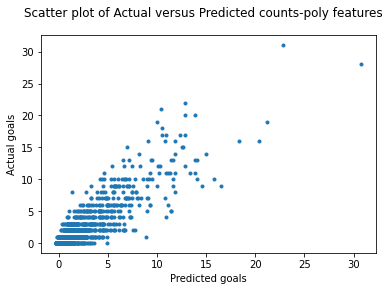

In [259]:
lm_poly.fit(X_poly, y)


lm_poly.score(X_poly, y)

lm_poly.intercept_


#clf.coef_
lm_poly.intercept_
pred_x=lm_poly.predict(X_poly)

plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts-poly features')
plt.scatter(x=pred_x, y=y, marker='.')
plt.xlabel('Predicted goals')
plt.ylabel('Actual goals')
plt.show()

#score_estimator(poisson_glm, df_test)

In [151]:
lm_poly.score(X, y)

0.7713177275982106

In [149]:
lm.score(X,y)

0.7713177275982106

In [261]:
lm_poly.intercept_.round(3)

-0.205

In [317]:
lm_poly.coef_

array([-2.85910574e-16,  8.88658121e-02,  9.92221112e-02,  1.00702687e-01,
       -2.08028742e-02, -7.68166936e-03, -1.31851208e-02,  3.22398355e-04,
       -7.68166936e-03, -1.31851208e-02,  2.76609700e-02,  1.42646902e-04,
        2.27259865e-04,  9.92221112e-02,  6.93889390e-18,  1.34714960e-01,
       -7.68166936e-03,  0.00000000e+00,  1.00702687e-01,  8.36475019e-02,
        0.00000000e+00, -1.31851208e-02, -2.08028742e-02, -4.18180015e-02,
       -3.76936935e-02,  1.42646902e-04,  0.00000000e+00,  2.27259865e-04])

In [419]:
X

,shots,Pos_DEF,Pos_GKO,Squad_Top,DefXshots,GKOXshots
0,18.0,1,0,0,18.0,0.0
1,32.0,0,0,1,0.0,0.0
2,56.0,0,0,0,0.0,0.0
3,20.0,1,0,0,20.0,0.0
4,0.0,0,1,1,0.0,0.0
...,...,...,...,...,...,...
2086,65.0,0,0,0,0.0,0.0
2087,23.0,1,0,1,23.0,0.0
2088,0.0,1,0,0,0.0,0.0
2089,5.0,1,0,1,5.0,0.0
